# Histopathologic Cancer Detection

# Imports and Paths

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

# fastai 1.0
from fastai import *
from fastai.vision import *
from torchvision.models import *    # import *=all the models from torchvision  

CROP_SIZE = 90 
arch = densenet169                  # specify model architecture, densenet169 seems to perform well for this data but you could experiment
BATCH_SIZE = 128                    # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = CROP_SIZE                      # input size is the crop size
MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'

MODEL_NAME = "densenet169_aug"

data = pd.read_csv('/home/josen/datasets/histopathologic-cancer-detection/train_labels.csv')
train_path = '/home/josen/datasets/histopathologic-cancer-detection/train/'
test_path = '/home/josen/datasets/histopathologic-cancer-detection/test/'
# quick look at the label stats
data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

# Data Preparation

In [2]:
from sklearn.model_selection import train_test_split

# we read the csv file earlier to pandas dataframe, now we set index to id so we can perform
train_df = data.set_index('id')

#If removing outliers, uncomment the four lines below
#print('Before removing outliers we had {0} training samples.'.format(train_df.shape[0]))
#train_df = train_df.drop(labels=too_dark_idx, axis=0)
#train_df = train_df.drop(labels=too_bright_idx, axis=0)
#print('After removing outliers we have {0} training samples.'.format(train_df.shape[0]))

train_names = train_df.index.values
train_labels = np.asarray(train_df['label'].values)

# split, this function returns more than we need as we only need the validation indexes for fastai
tr_n, tr_idx, val_n, val_idx = train_test_split(train_names, range(len(train_names)), test_size=0.1, stratify=train_labels, random_state=123)

# create dataframe for the fastai loader
train_dict = {'name': train_path + train_names, 'label': train_labels}
df = pd.DataFrame(data=train_dict)
# create test dataframe
test_names = []
for f in os.listdir(test_path):
    test_names.append(test_path + f)
df_test = pd.DataFrame(np.asarray(test_names), columns=['name'])

# Data Visualization

Text(0, 0.5, 'Tumor tissue samples')

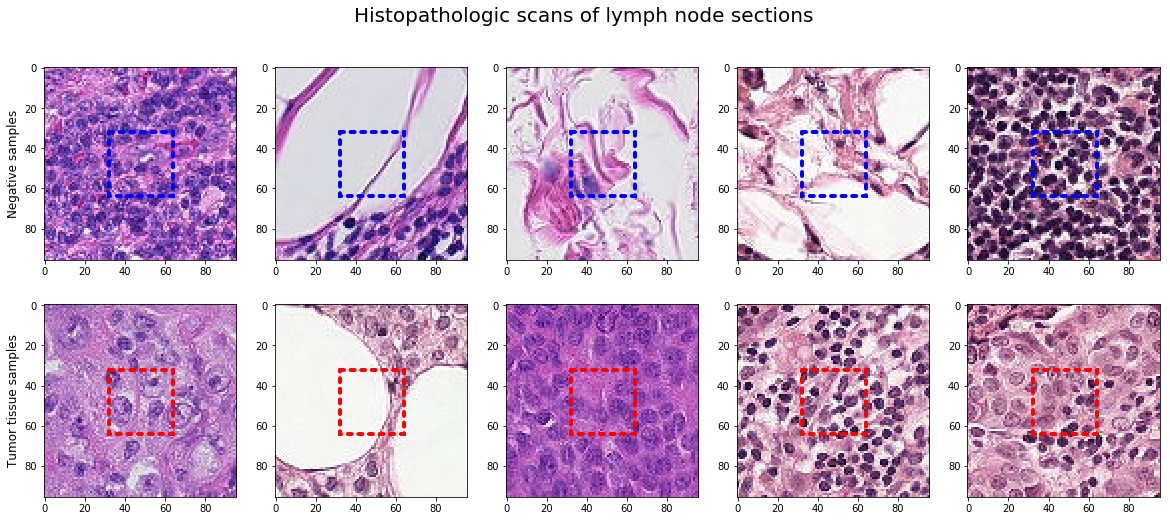

In [3]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

# random sampling
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

# Data Augmentation

In [4]:
transforms = get_transforms(do_flip = True, flip_vert = True, max_rotate = 0.0, max_warp = 0.0)
transforms[1][0] = dihedral()


# Create ImageDataBunch using fastai data block API
imgDataBunch = (ImageList.from_df(path='/', df=df, suffix='.tif')
        #Where to find the data?
        .split_by_idx(val_idx)
        #How to split in train/valid?
        .label_from_df(cols='label')
        #Where are the labels?
        .add_test(ImageList.from_df(path='/', df=df_test))
        #dataframe pointing to the test set?
        .transform(tfms=transforms, size=sz)
        # We have our custom transformations implemented in the image loader but we could apply transformations also here
        # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
        .databunch(bs=BATCH_SIZE)
        # convert to databunch
        .normalize([tensor([0.702447, 0.546243, 0.696453]), tensor([0.238893, 0.282094, 0.216251])])
        # Normalize with training set stats. These are means and std's of each three channel and we calculated these previously in the stats step.
       )

In [5]:
# Next, we create a convnet learner object
# ps = dropout percentage (0-1) in the final layer
def getLearner():
    return create_cnn(imgDataBunch, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

learner = getLearner()

/home/josen/py-36-env/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,accuracy,time
0,0.228807,0.245435,0.899286,03:48
1,0.211137,0.224600,0.912057,03:44
2,0.196525,0.191094,0.926465,03:46
3,0.177119,0.176173,0.943690,03:51
4,0.164585,0.148358,0.948098,03:54
5,0.152304,0.134560,0.952552,03:55
6,0.138958,0.125118,0.955097,03:55
7,0.137121,0.124788,0.955142,03:55


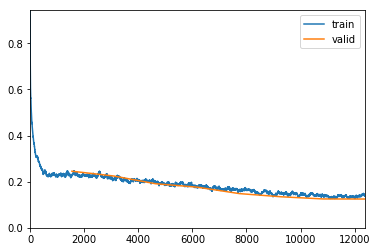

In [6]:
max_lr = 2e-2
wd = 1e-4
# 1cycle policy
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

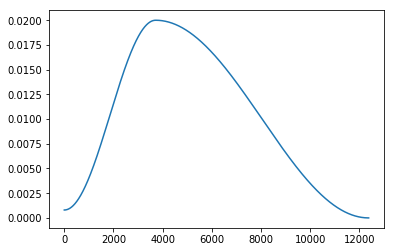

In [7]:
# plot learning rate of the one cycle
learner.recorder.plot_lr()

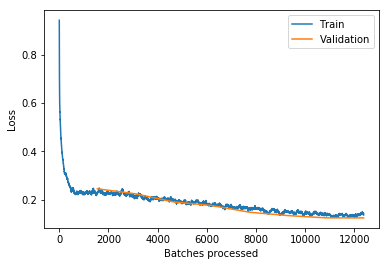

In [8]:
# and plot the losses of the first cycle
learner.recorder.plot_losses()

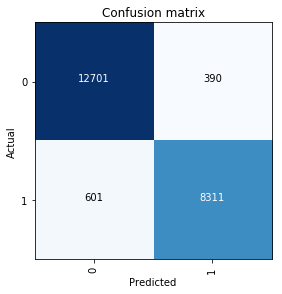

In [9]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [10]:
# before we continue, lets save the model at this stage
learner.save(MODEL_PATH + MODEL_NAME + '_stg1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


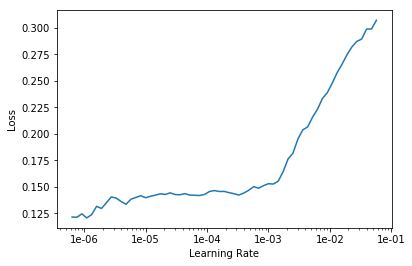

In [11]:
# load the baseline model
learner.load(MODEL_PATH + MODEL_NAME + '_stg1')

# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find(wd=wd)

# plot learning rate finder results
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.134499,0.124989,0.954643,05:11
1,0.144127,0.128603,0.951734,05:10
2,0.140252,0.123460,0.955370,05:13
3,0.131300,0.121557,0.955915,05:13
4,0.129936,0.113263,0.960096,05:11
5,0.112456,0.105541,0.962005,05:12
6,0.104675,0.100374,0.963914,05:12
7,0.101180,0.095904,0.965959,05:13
8,0.092099,0.092987,0.966868,05:12
9,0.083374,0.087735,0.969231,05:14


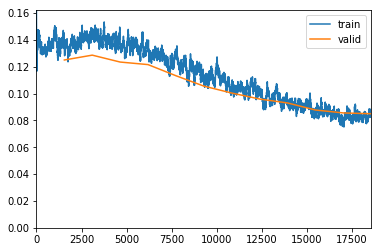

In [12]:
# Now, smaller learning rates. This time we define the min and max lr of the cycle
learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))

In [13]:
# Save the finetuned model
learner.save(MODEL_PATH + MODEL_NAME + '_stg2')

In [14]:
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.9708676338195801 %.


# Results
 * train_loss valid_loss valid_acc
 * Densenet169+OneCycle+NoAugmentation = 0.002263	0.376988 0.970504
 * Densenet169+OneCycle+Augmentation = 0.092341	0.097588	0.969959

# Validation and Submission

In [15]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9947773445637477


In [16]:
# make sure we have the best performing model stage loaded
learner.load(MODEL_PATH + MODEL_NAME + '_stg2')

# Fastai has a function for this but we don't want the additional augmentations it does (our image loader has augmentations) so we just use the get_preds
preds_test,y_test=learner.TTA(ds_type=DatasetType.Test)

# We do a fair number of iterations to cover different combinations of flips and rotations.
# The predictions are then averaged.
#n_aug = 12
#preds_n_avg = np.zeros((len(learner.data.test_ds.items),2))
#for n in tqdm_notebook(range(n_aug), 'Running TTA...'):
#    preds,y = learner.get_preds(ds_type=DatasetType.Test, with_loss=False)
#    preds_n_avg = np.sum([preds_n_avg, preds.numpy()], axis=0)
#preds_n_avg = preds_n_avg / n_aug

In [19]:
n_aug = 12
preds_n_avg = np.zeros((len(learner.data.test_ds.items),2))

preds_n_avg = np.sum([preds_n_avg, preds_test.numpy()], axis=0)
preds_n_avg = preds_n_avg / n_aug
print(preds_n_avg)

# Next, we will transform class probabilities to just tumor class probabilities
print('Negative and Tumor Probabilities: ' + str(preds_n_avg[0]))
tumor_preds = preds_n_avg[:, 1]
print('Tumor probability: ' + str(tumor_preds[0]))
# If we wanted to get the predicted class, argmax would get the index of the max
class_preds = np.argmax(preds_n_avg, axis=1)
classes = ['Negative','Tumor']
print('Class prediction: ' + classes[class_preds[0]])

[[7.432655e-02 9.006786e-03]
 [4.177719e-05 8.329156e-02]
 [8.317210e-02 1.612358e-04]
 [8.195377e-02 1.379564e-03]
 ...
 [7.924950e-02 4.083837e-03]
 [8.331300e-02 2.033585e-05]
 [5.359447e-05 8.327974e-02]
 [1.449366e-02 6.883968e-02]]
Negative and Tumor Probabilities: [0.074327 0.009007]
Tumor probability: 0.00900678647061189
Class prediction: Negative


In [20]:
# get test id's from the sample_submission.csv and keep their original order
SAMPLE_SUB = '/home/josen/datasets/histopathologic-cancer-detection/sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id)

# List of tumor preds. 
# These are in the order of our test dataset and not necessarily in the same order as in sample_submission
pred_list = [p for p in tumor_preds]

# To know the id's, we create a dict of id:pred
pred_dic = dict((key, value) for (key, value) in zip(learner.data.test_ds.items, pred_list))

# Now, we can create a new list with the same order as in sample_submission
pred_list_cor = [pred_dic['///home/josen/datasets/histopathologic-cancer-detection/test/' + id + '.tif'] for id in sample_list]

# Next, a Pandas dataframe with id and label columns.
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})

# Export to csv
df_sub.to_csv('{0}_submission.csv'.format(MODEL_PATH), header=True, index=False)